### European wholesale electricity price data
https://ember-climate.org/data-catalogue/european-wholesale-electricity-price-data/

In [1]:
import warnings
warnings.filterwarnings('ignore')
import requests, io
import pandas as pd
url = 'https://ember-climate.org/app/uploads/2022/09/european_wholesale_electricity_price_data_monthly-5.csv'
df = pd.read_csv(io.StringIO(requests.get(url).text))
df = df[df.Country == 'France'].drop(columns=['Country','ISO3 Code']).rename(columns={'Price (EUR/MWhe)':'Price'}).set_index('Date')
df.index = pd.date_range(df.index.min(), periods=len(df), freq="M")
df.T

,2015-01-31,2015-02-28,2015-03-31,2015-04-30,2015-05-31,2015-06-30,2015-07-31,2015-08-31,2015-09-30,2015-10-31,...,2022-07-31,2022-08-31,2022-09-30,2022-10-31,2022-11-30,2022-12-31,2023-01-31,2023-02-28,2023-03-31,2023-04-30
Price,41.95,50.14,43.79,39.52,26.46,32.16,37.91,32.19,37.45,44.96,...,400.95,492.99,393.55,178.89,192.16,270.49,132.28,148.78,111.81,106.45


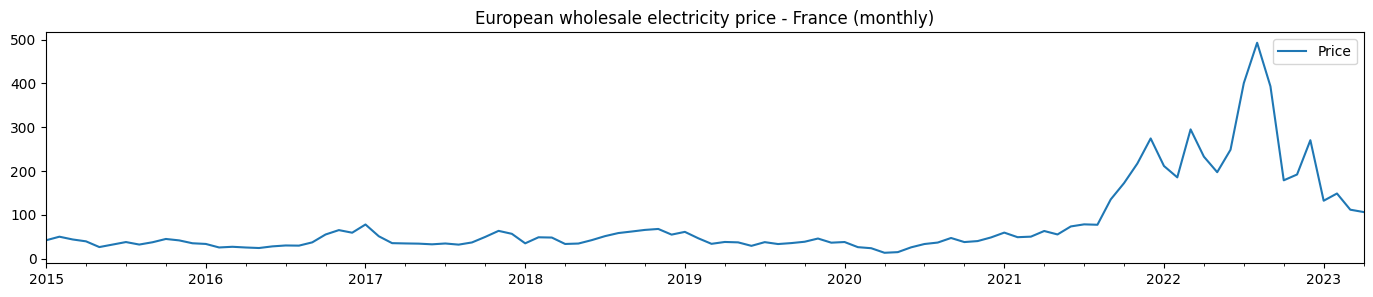

In [2]:
df.plot(figsize=(17,3), title='European wholesale electricity price - France (monthly)');

### Forecast from 2021-09-30

#### Train and Test split

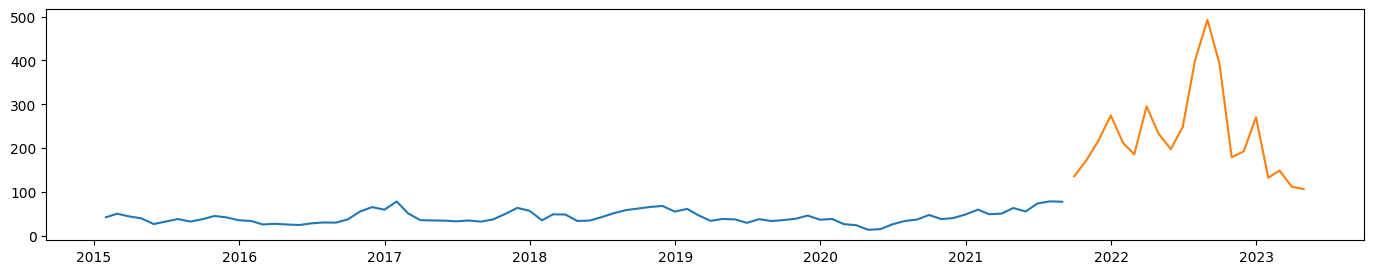

In [3]:
import matplotlib.pyplot as plt
plt.figure(figsize=(17,3))
train = df.loc[:'2021-08-31']
test = df.loc['2021-09-30':]
plt.plot(train)
plt.plot(test);

In [6]:
print('Train sample size {:.0%}'.format(len(train)/len(df)))

Train sample size 80%


#### PACF

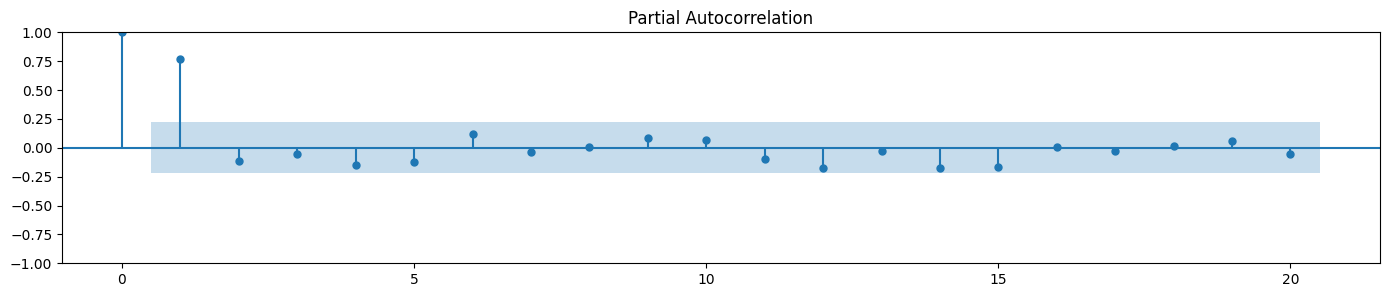

In [4]:
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = (17,3)
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
plot_pacf(train);

We see 1-2 AR lags

#### ADF test

In [7]:
%precision 6
from statsmodels.tsa.stattools import adfuller
adf = adfuller(train)
adf

(-2.409861,
 0.138972,
 0,
 79,
 {'1%': -3.515977, '5%': -2.898886, '10%': -2.586694},
 489.188067)

Since the p-value is greater than **.05**, we cannot reject the null hypothesis of non-stationarity

#### KPSS test

In [8]:
#import warnings
#warnings.filterwarnings('ignore')
%precision 6
from statsmodels.tsa.stattools import kpss
KPSS = kpss(train)
KPSS

/tmp/ipykernel_2051/2200803523.py:5: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  KPSS = kpss(train)


(0.180899,
 0.100000,
 4,
 {'10%': 0.347000, '5%': 0.463000, '2.5%': 0.574000, '1%': 0.739000})

So we fail to reject the Null hypothesis of stationarity with p-value > 0.1

**Contradictory results of ADF and KPSS unit root tests - maybe not enough observations**

#### SARIMA
So we choose our model among AR(1-2), I(0-1) combinations and predefined seasonality 12 by mimimum AIC and significance of AR coefficients

**SARIMA(1,0,0)(2,1,0)[12]**

In [26]:
import statsmodels.api as sm
fit = sm.tsa.statespace.SARIMAX(train, order=(1,0,0), seasonal_order=(2, 1, 0, 12)).fit(disp=0)
fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                     SARIMAX Results                                      
==========================================================================================
Dep. Variable:                              Price   No. Observations:                   80
Model:             SARIMAX(1, 0, 0)x(2, 1, 0, 12)   Log Likelihood                -249.339
Date:                            Tue, 23 May 2023   AIC                            506.679
Time:                                    13:34:45   BIC                            515.557
Sample:                                01-31-2015   HQIC                           510.197
                                     - 08-31-2021                                         
Covariance Type:                              opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8474      0.063     13.446      0.000       0.724       0.971
ar.S.L12      -0.9003      0.115     -7.827      0.000      -1.126      -0.675
ar.S.L24      -0.4235      0.103     -4.126      0.000      -0.625      -0.222
sigma2        75.2501     12.628      5.959      0.000      50.501     100.000
===================================================================================
Ljung-Box (L1) (Q):                   0.13   Jarque-Bera (JB):                 0.44
Prob(Q):                              0.71   Prob(JB):                         0.80
Heteroskedasticity (H):               1.39   Skew:                             0.01
Prob(H) (two-sided):                  0.44   Kurtosis:                         3.39
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

#### Prediction

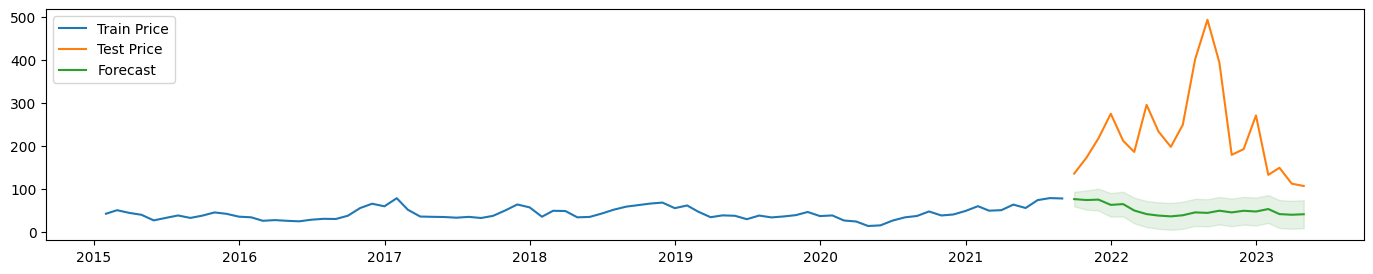

In [8]:
prediction = fit.get_forecast(steps=len(test))
pred = prediction.predicted_mean
ci = prediction.conf_int()
plt.plot(train, label='Train Price')
plt.plot(test, label='Test Price')
plt.plot(pred, label='Forecast')
plt.fill_between(ci.index, ci['lower Price'], ci['upper Price'], color='g', alpha=0.1)
plt.legend(loc='upper left');

### Model search iterations (by goodness of fit) ---> Overfitting

In [ ]:
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import statsmodels.api as sm
from statsmodels.tools.eval_measures import rmse
from itertools import product
errors = []
order = []
season = []
for i in product([0, 1, 2], repeat=3):
    for j in product([0, 1, 2], repeat=3):
        # print('SARIMAX'+str(i)+str(j+(12,)))
        try: 
            fit = sm.tsa.statespace.SARIMAX(train, order=i, seasonal_order=j+(12,)).fit(disp=0)
            errors.append(rmse(fit.get_forecast(steps=len(test)).predicted_mean, test).sum())
            order.append(i)
            season.append(j+(12,))
        except:
            pass
results = pd.DataFrame({'Order':order, 'Seasonal':season, 'RMSE':errors})
results.sort_values('RMSE', inplace=True, ignore_index=True)

In [7]:
results.head()

,Order,Seasonal,RMSE
0,"(2, 2, 1)","(0, 2, 0, 12)",2567.699575
1,"(0, 2, 2)","(0, 2, 0, 12)",2573.511590
2,"(2, 2, 2)","(0, 2, 0, 12)",2579.521750
3,"(2, 2, 0)","(1, 2, 0, 12)",2582.041771
4,"(2, 2, 2)","(1, 2, 0, 12)",2583.255468


Minimal Root Mean Square Error sum comes from **SARIMA(2,2,1)(0,2,0)[12]** model

#### Prediction
Insample + 8 periods out of sample

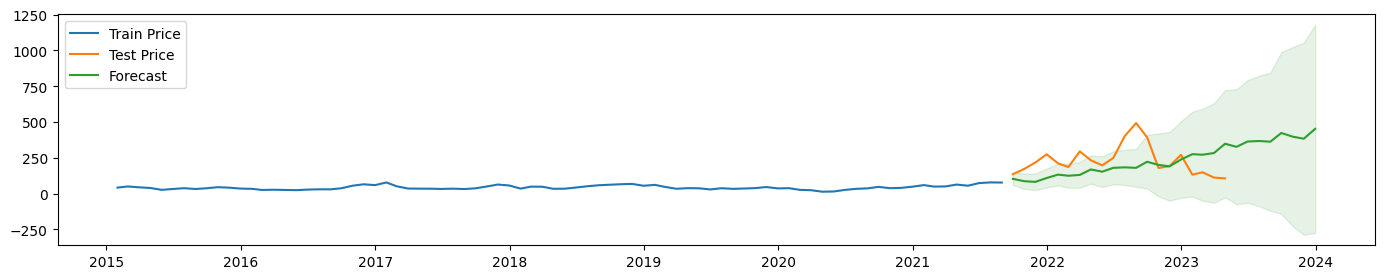

In [27]:
import statsmodels.api as sm
fit = sm.tsa.statespace.SARIMAX(train, order=(2,2,1), seasonal_order=(0, 2, 0, 12)).fit(disp=0)
prediction = fit.get_forecast(steps=len(test)+8)
pred = prediction.predicted_mean
ci = prediction.conf_int()
import matplotlib.pyplot as plt
plt.figure(figsize=(17,3))
plt.plot(train, label='Train Price')
plt.plot(test, label='Test Price')
plt.plot(pred, label='Forecast')
plt.fill_between(ci.index, ci['lower Price'], ci['upper Price'], color='g', alpha=0.1)
plt.legend(loc='upper left');

We observe a strong overfitting of the model